In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.steward import DataSteward
from utils.dataManagers.informations import informer
from utils.clf_results import clfResult

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

Standardization can be more practical for many machine learning algorithms. The reason is that many linear
models, such as the logistic regression and SVM initialize the weights to 0 or small random values close to 0. 
Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of
a normal distribution, which makes it easier to learn the weights. Furthermore, standardization maintains useful information about outliers and makes the
algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

def get_submission(predictions, predictions_file_name=None):
    df = pd.DataFrame(predictions, columns=['SalePrice'])
    df.index = test.index
    df[df.SalePrice < 0] = 0
    if predictions_file_name:
        df.to_csv(f'scores/{predictions_file_name}.csv')
    return df

def get_number_types(df):
    return df.select_dtypes(['int64', 'float64']) 

def get_df_for_predictions(train, test, standardize=True):
    all_data = pd.concat((train, test))

    if standardize:
        sd = StandardScaler()
        train_num_types = get_number_types(train)
        num_type_columns = train_num_types.columns
        train_num_types = sd.fit_transform(train_num_types)
        test_num_types = sd.transform(get_number_types(test))

        number_type = pd.DataFrame(np.concatenate((train_num_types, test_num_types)), columns=num_type_columns, index=all_data.index)
    else:
        number_type = get_number_types(all_data)

    categorical = all_data.select_dtypes(['category'])
    if categorical.shape[1] > 0:
        df = number_type.join(pd.get_dummies(categorical))
    else:
        df = number_type
    return df.iloc[:train.shape[0], :], df.iloc[train.shape[0]:, :]


In [3]:
def log_given_columns(df, cols):
    ret_df = df.copy()
    ret_df[cols] = np.log1p(ret_df[cols])
    return ret_df

def restore_predictions_from_log1p(predictions):
    return np.expm1(predictions)

def power_columns(in_df, cols, power):
    df = in_df.copy()
    for col in cols:
        df[f'{col}_{power}'] = np.power(df[col], power)
        del df[col]
    return df

def plot_train_vs_test_score(grid, yscale='linear'):
    fig, ax = plt.subplots()
    best_param = grid.best_params_['alpha']
    train_score = grid.cv_results_['mean_train_score']
    test_score = grid.cv_results_['mean_test_score']
    
    plt.plot(alphas, np.sqrt(-train_score), label='train score')
    plt.plot(alphas, np.sqrt(-test_score), label='cross val score')
    plt.scatter(alphas, np.sqrt(-train_score))
    plt.scatter(alphas, np.sqrt(-test_score))
    plt.axvline(x=best_param, color='r', label=f'choosed parameter alpha= {best_param}')
    plt.legend()
    plt.title('Train vs test scores error')
    plt.xlabel('Alpha values')
    plt.ylabel('Root mean squared log error')
    plt.yscale(yscale)

def plot_accual_vs_predicted_test_scores(ytrain, grid):
    fig, ax = plt.subplots()
    preds = grid.predict(trainWithDummies)
    p = sns.regplot(preds, ytrain)
    plt.title('Accual vs predicted test scores')
    plt.xlabel('Predictions')
    plt.ylabel('Accual')
    
def predict(clf, xtrain, ytrain, test, name,
            store_classifier=False, store_predictions=True,
            plot_best_predictors=True, plot_train_vs_test=True,
            plot_accual_vs_predicted_test=True, predictions_form_restoring_method=None):
    grid = GridSearchCV(clf, param_grid, scoring='neg_mean_squared_log_error')
    grid.fit(xtrain, ytrain)
    
    predictions = grid.predict(test)
    if predictions_form_restoring_method is not None:
        predictions = predictions_form_restoring_method(predictions)

    results = clfResult(grid.best_estimator_, name, test.columns,
                        predictions, grid.best_params_, store_classifier=store_classifier, store_predictions=store_predictions)
    if plot_best_predictors:
        results.plot_best_predictors(20)
    if plot_train_vs_test:
        plot_train_vs_test_score(grid)
    if plot_accual_vs_predicted_test:
        plot_accual_vs_predicted_test_scores(ytrain, grid)
    return results, grid

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


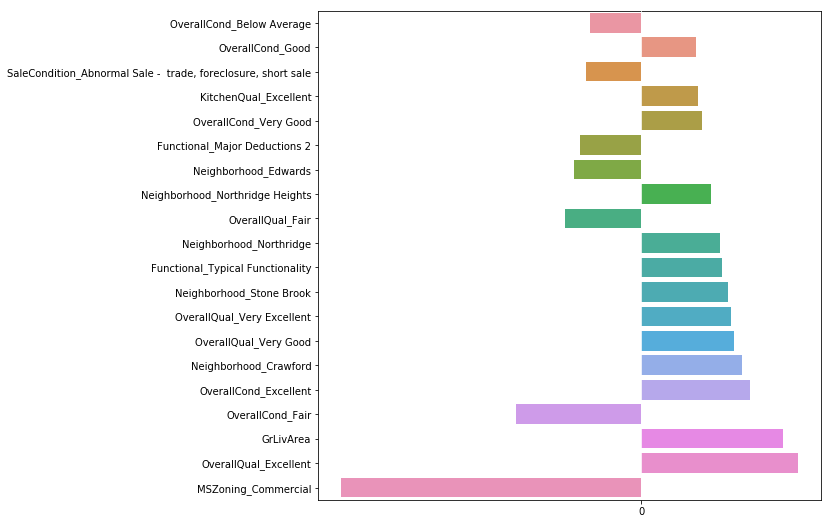

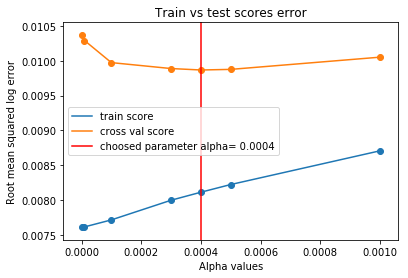

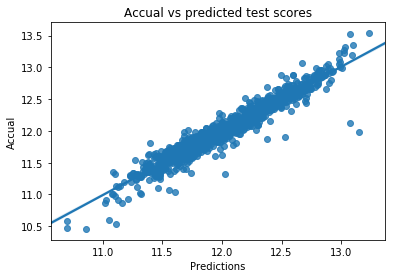

In [56]:
from scipy.stats import skew
number_type = train.select_dtypes(['int64', 'float64']) 

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results, grid = predict(Lasso(normalize=False, max_iter=5000), trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

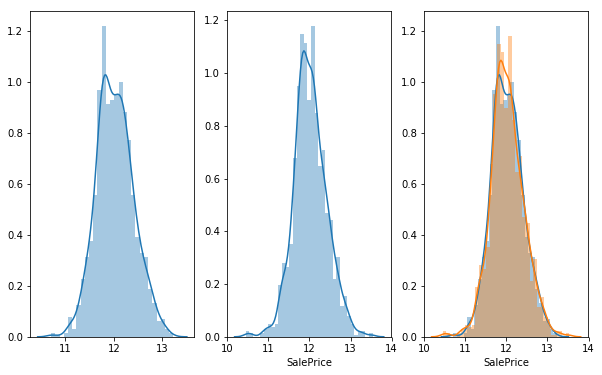

In [59]:
preds = grid.predict(trainWithDummies)
fig, ax = plt.subplots(ncols=3, figsize=[10, 6])
sns.distplot(preds, ax=ax[0])
sns.distplot(preds, ax=ax[2])
sns.distplot(np.log1p(ytrain), ax=ax[1])
sns.distplot(np.log1p(ytrain), ax=ax[2])

In [16]:
df = train.copy()
df['SalePrice'] = ytrain
corr = df.corr()

sale_price_corrs = corr.SalePrice
del corr['SalePrice']

In [5]:
def calculate_corr_rank_power(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.power(row.values, 2)) - 1)

def calculate_corr_rank_abs(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.abs(row.values)) - 1)

In [44]:
corr_rank = dict()
_ = corr.apply(calculate_corr_rank_abs, axis=1)

In [48]:
corr_rank = dict()
_ = corr.apply(calculate_corr_rank_power, axis=1)

In [49]:
best_corrs = np.abs(pd.Series(corr_rank))
best_corrs = best_corrs[best_corrs > np.median(best_corrs)]
if 'SalePrice' in best_corrs:
    del best_corrs['SalePrice']
best_corrs

3SsnPorch        1.650079
EnclosedPorch    0.307554
Fireplaces       0.341533
HalfBath         0.255205
KitchenAbvGr     0.495152
LotArea          0.396751
LotFrontage      0.289050
MasVnrArea       0.348140
MiscVal          1.245191
MoSold           0.896358
OpenPorchSF      0.390957
PoolArea         0.491043
ScreenPorch      0.832861
WoodDeckSF       0.450854
YearRemodAdd     0.275442
YrSold           0.569341
dtype: float64

In [52]:
my_pick = ['Neighborhood', 'TotalBsmtSF', 'Heating', 'HeatingQC', 
               'BsmtFinType1', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageFinish', 'HouseStyle', 'MSSubClass']

#removing duplicates with set
best_columns = list(set(list(best_corrs.index) + my_pick))
len(best_columns)

27

In [14]:
def get_number_and_categoricals(df):
    return df.select_dtypes(['int64', 'float64']), df.select_dtypes(['category']) 

def get_skeved_columns(df, skew_threshold=1):
    skewness = df.apply(lambda x: skew(x))
    mask = np.abs(skewness.sort_values()) >= 1
    return mask[mask].index

def perform_data_transformations(df, columnsSubset, colsToLog):
    number_type, categorical_type = get_number_and_categoricals(df[columnsSubset])
    colsToLog_subset = [c for c in colsToLog if c in best_columns]
    
    number_type = number_type.join(number_type[colsToLog_subset].apply(np.log1p), rsuffix='_log1p')
    number_type.drop(colsToLog_subset, axis=1, inplace=True)
    return number_type.join(categorical_type)

c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

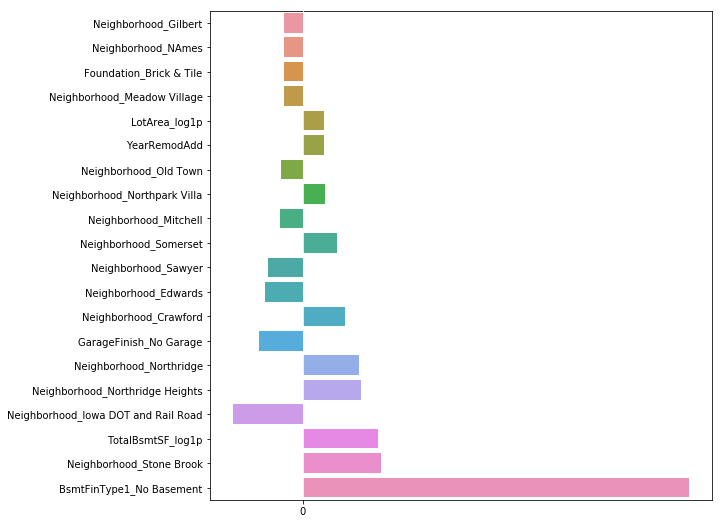

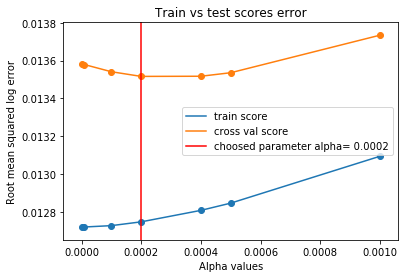

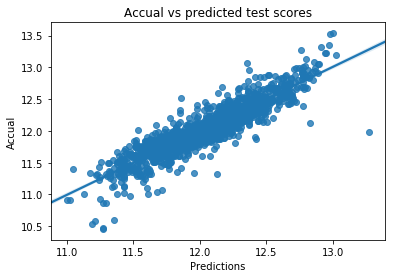

In [53]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

number_type = get_number_types(train)
colsToLog = get_skeved_columns(number_type, .75)
trainTransformed = perform_data_transformations(train, best_columns, colsToLog)
testTransformed = perform_data_transformations(test, best_columns, colsToLog)

trainWithDummies, testWithDummies = get_df_for_predictions(trainTransformed, testTransformed)

alphas = [1e-7, 1e-5, 1e-4, 2e-4, 4e-4, 5e-4, 1e-3]
# alphas = [1e-7, 1e-5, 1e-4, 1e-3, 3e-3, 4e-3, 5e-3, 1e-2]
# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results, grid = predict(Lasso(normalize=False), trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged_best_columns_based_on_corr_rank_and_my_picks_63cols_abs',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

* somethings wrong- lot area its like 30'th best prediction
* best score is .023- best score on test is .134- so we overfit
* try using http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

In [175]:
%%timeit
from sklearn.model_selection import cross_val_score
grid = GridSearchCV(Lasso(normalize=False), param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv_score = cross_val_score(grid, trainWithDummies, np.log1p(ytrain), scoring='neg_mean_squared_error', cv=5,  n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_score), np.std(cv_score)))

7.98 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matka\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

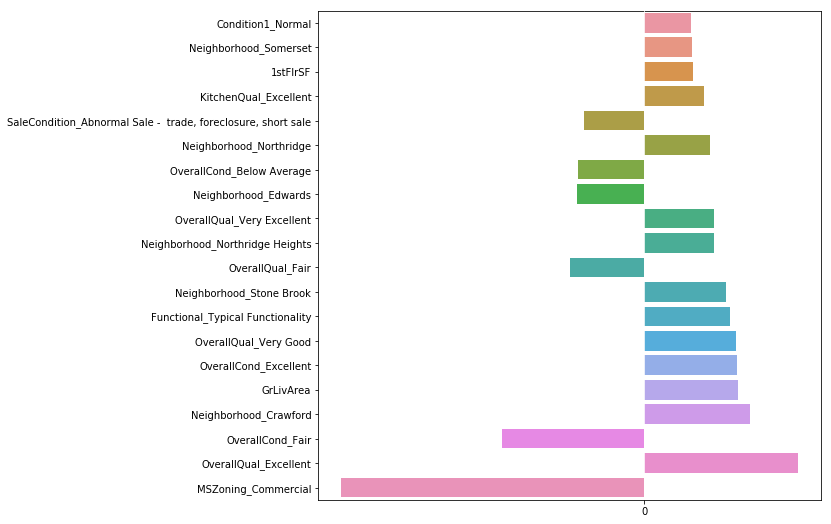

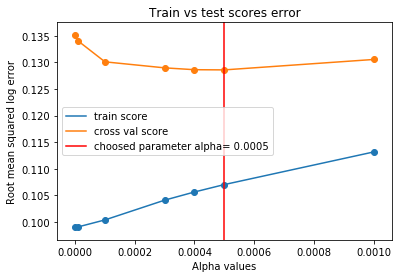

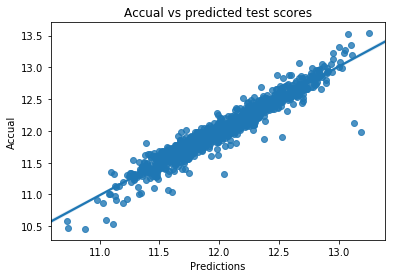

In [116]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

number_type = get_number_types(train)
colsToLog = get_skeved_columns(number_type, .75)

train_log = log_given_columns(train, colsToLog)
test_log = log_given_columns(test, colsToLog)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results, grid = predict(Lasso(normalize=False), trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)